# Linear regression for the labeled data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Load data

In [5]:
df_results = pd.read_csv('generated_results_1202_labeled.csv', sep = '\t')
df_results

,sample,method,masked,grey,red,green,blue,SRM,EBC,brightness
0,3,random sampling,True,242,244,244,221,1,2,151
1,3,pca + random sampling,True,239,242,243,218,1,2,149
2,3,most dominant,True,240,243,244,220,1,2,150
3,3,pca + most dominant,True,241,241,242,218,1,2,150
4,3,raw,False,193,195,196,178,1,2,121
...,...,...,...,...,...,...,...,...,...,...
630,1,random sampling,True,243,243,244,237,1,2,154
631,1,pca + random sampling,True,242,242,243,235,1,2,153
632,1,most dominant,True,243,243,244,236,1,2,154
633,1,pca + most dominant,True,243,243,244,236,1,2,154


In [6]:
print(set(df_results.method))
#select only the EBC samples
df_labeled = df_results[df_results['sample'].str.contains('EBC') ].copy()
#retrieve EBC value from samplen name
df_labeled['EBC label'] = df_labeled['sample'].str[3:5].astype(int)
# split results in most dominant and random sampling
df_rand = df_labeled[(df_labeled.method=='random sampling') | (df_labeled.method=='pca + random sampling') ]
df_most = df_labeled[(df_labeled.method=='most dominant') | (df_labeled.method=='pca + most dominant') ]

{'most dominant', 'random sampling', 'raw', 'pca + most dominant', 'pca + random sampling'}


AttributeError: Can only use .str accessor with string values!

# Explore data

To see the difference between pre-processed with PCA and not preprocessed with PCA data is plotted per method

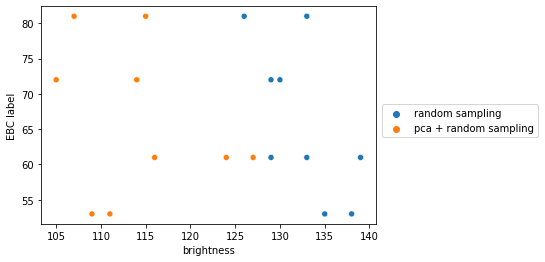

In [3]:
sns.scatterplot(data=df_rand, x='brightness', y='EBC label', hue='method')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.savefig('bright_ebc_randsampling.jpeg')

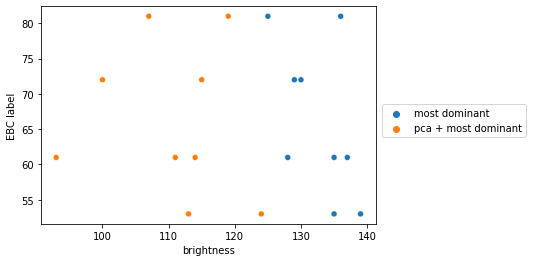

In [4]:
sns.scatterplot(data=df_most, x='brightness', y='EBC label', hue='method')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.savefig('bright_ebc_most.jpeg')

As we can see the PCA method introduces more variation and is less suitable for regression. This is the case for both most dominant + PCA and random sampling + PCA

# model without PCA processing

As depicted above brightness and grey value might be used for the regression model

In [5]:
def model_data(df, method):
    df = df[df_labeled.method==method] 
    y = df['EBC label']
    X = np.array(df[['grey', 'brightness']])
    object= StandardScaler()
    scale = object.fit_transform(X) 
    reg = LinearRegression().fit(X, y)
    pred = reg.predict(X)
    df['predicted EBC'] = pred
    return df


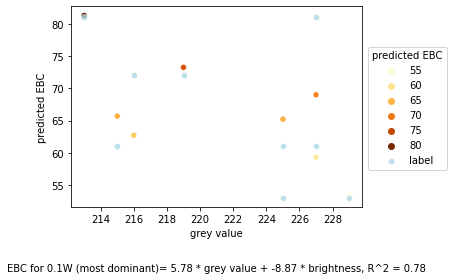

In [6]:
method = 'most dominant'

data = df_labeled
df = model_data(data, method)
#title is from evaluation
title = 'EBC for 0.1W (most dominant)= 5.78 * grey value + -8.87 * brightness, R^2 = 0.78'
sns.scatterplot(data=df, x='grey', y='predicted EBC', hue = 'predicted EBC', palette = "YlOrBr")
sns.scatterplot(data=df, x='grey', y='EBC label', color = 'lightblue', alpha = 0.8, label = 'label')
plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title = 'predicted EBC')
plt.xlabel(f'''grey value\n

{title}''')
plt.tight_layout()
plt.savefig(f'regression_{method}.jpeg')


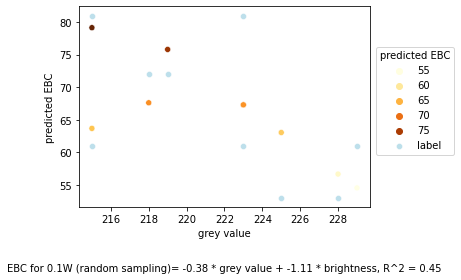

In [7]:
method = 'random sampling'

data = df_labeled
df = model_data(data, method)
#title is from evaluation
title = 'EBC for 0.1W (random sampling)= -0.38 * grey value + -1.11 * brightness, R^2 = 0.45'
sns.scatterplot(data=df, x='grey', y='predicted EBC', hue = 'predicted EBC', palette = "YlOrBr")
sns.scatterplot(data=df, x='grey', y='EBC label', color = 'lightblue', alpha = 0.8, label = 'label')
plt.legend(bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title = 'predicted EBC')
plt.xlabel(f'''grey value\n

{title}''')
plt.tight_layout()
plt.savefig(f'regression_{method}.jpeg')

This is a proof of principle. The combination of greyvalue and calculated brightness does predict EBC values that are comparable with the labels. This is only predicted for 0.1 White brightness configuration. It is advisable to gather more samples per brightness configuration. 

# Evaluation of models

In [8]:
def evaluate_(df, method):
    df = df[df_labeled.method==method] 
    y = df['EBC label']
    X = np.array(df[['grey', 'brightness']])
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3, random_state=0)
    print(len(X_train), len(X_test))
    reg = LinearRegression().fit(X_train, y_train)
    y_predicted = reg.predict(X_test)
    # model evaluation for testing set
    mse = metrics.mean_squared_error(y_test, y_predicted)
    r2 = metrics.r2_score(y_test, y_predicted)

    print("The model performance for testing set")
    print("--------------------------------------")
    print(f'EBC for 0.1W ({method})= {reg.coef_[0]:.2f} * grey value + {reg.coef_[1]:.2f} * brightness')
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))

In [9]:
method = 'random sampling'
data = df_labeled
evaluate_(data, method)

6 3
The model performance for testing set
--------------------------------------
EBC for 0.1W (random sampling)= -0.38 * grey value + -1.11 * brightness
MSE is 75.89569941842679
R2 score is 0.45267524457865294


In [10]:
method = 'most dominant'
data = df_labeled
evaluate_(data, method)

6 3
The model performance for testing set
--------------------------------------
EBC for 0.1W (most dominant)= 5.78 * grey value + -8.87 * brightness
MSE is 30.42077560994962
R2 score is 0.7806194066590172
